In [1]:
import pandas_datareader.data as web
import datetime as dt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,7)

#!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
# Import Data

start = dt.datetime(2017, 2, 27)
end = dt.datetime(2022, 2, 28)

stocks = ['AAPL']
df = web.DataReader(stocks,'yahoo',start,end)['Adj Close']
df.columns = ['Close']
df.tail()

,Close
Date,
2022-02-22,164.320007
2022-02-23,160.070007
2022-02-24,162.740005
2022-02-25,164.850006
2022-02-28,165.119995


In [3]:
df.describe()

,Close
count,1261.000000
mean,77.717197
std,43.591031
min,32.320957
25%,41.876419
50%,53.939484
75%,120.087021
max,181.778397


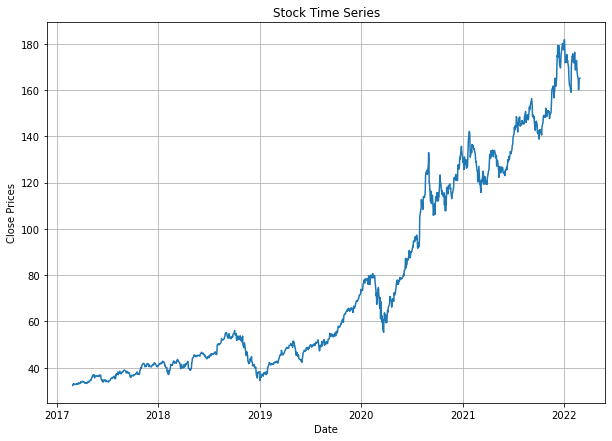

In [4]:
#plot close price
#plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Stock Time Series')
plt.show()

<AxesSubplot:ylabel='Density'>

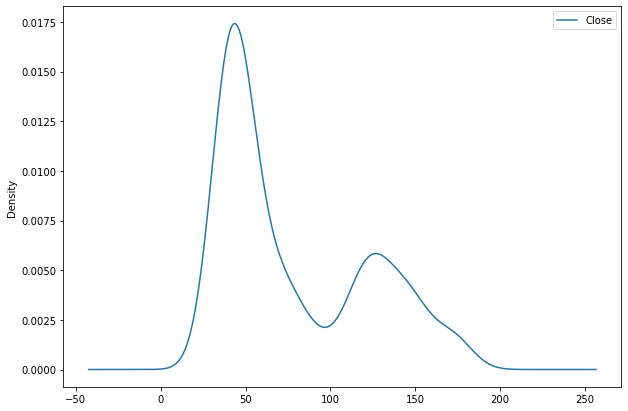

In [5]:
# Probability Distribution of the dataset
df_close = df['Close']
df.plot(kind='kde')

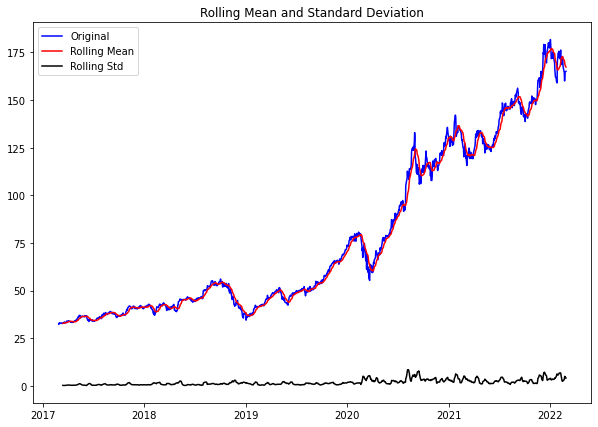

Results of dickey fuller test
Test Statistics                   0.485872
p-value                           0.984437
No. of lags used                 20.000000
Number of observations used    1240.000000
critical value (1%)              -3.435635
critical value (5%)              -2.863874
critical value (10%)             -2.568012
dtype: float64


In [6]:
#Test for staionarity The series becomes stationary if both the mean and standard deviation 
#are flat lines (constant mean and constant variance).

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)


#The increasing mean and standard deviation may be seen in the graph above, indicating that our series isn’t stationary.
#We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed 
#the critical values. As a result, the data is nonlinear.

{'adf': -7.799235721058389,
 'pvalue': 7.57120054186413e-12,
 'usedlag': 19,
 'nobs': 1240,
 'criticalvalues': {'1%': -3.435634587707382,
  '5%': -2.8638736617392837,
  '10%': -2.568012472034339},
 'icbest': 4825.365549776821}

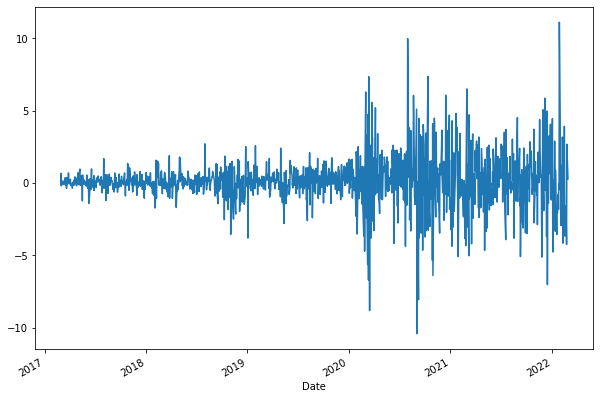

In [7]:
### Differencing the values converts the dataset from non-stationary to stationary. Goal P-value < .05
# Will be used to update d value in the p,d,q 

df['1difference']=df['Close']-df['Close'].shift(1)
 
df['1difference'].plot()

result=adfuller((df['1difference']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

<Figure size 720x504 with 0 Axes>

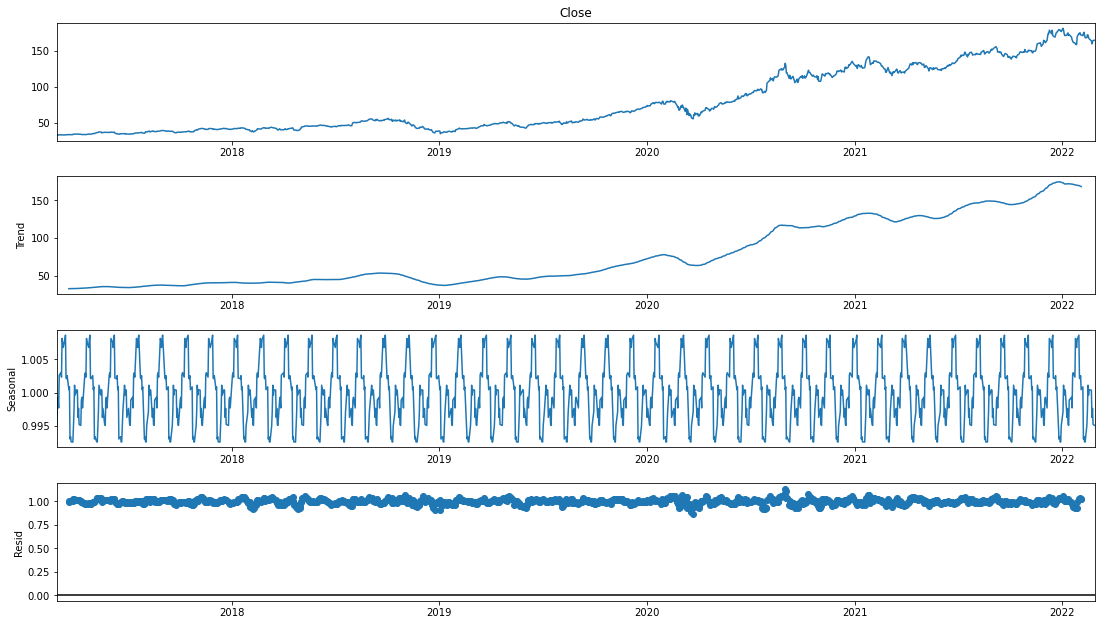

In [8]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


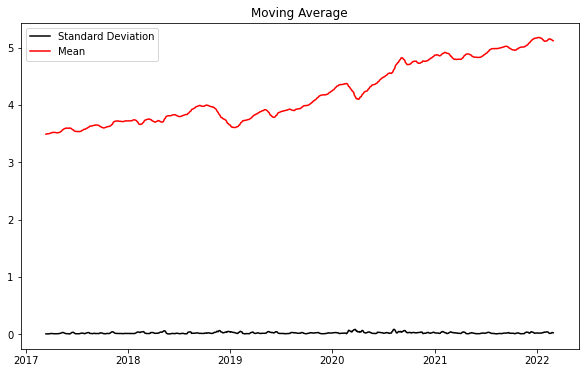

In [9]:
#To reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. 
#We then calculate the rolling average of the series after obtaining the log of the series. A rolling average is 
#computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point 
#in the series.

#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

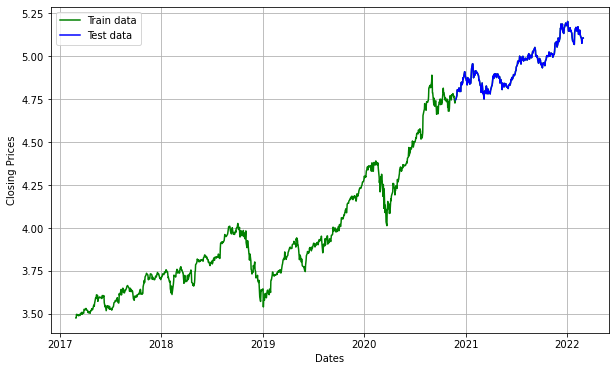

In [10]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.75)], df_log[int(len(df_log)*0.75):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4658.012, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4676.568, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4675.410, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4656.009, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4674.948, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4674.966, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4672.877, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4673.229, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.474 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  942
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2341.284
Date:                Tue, 01 Mar 2022   AIC                          -4676.568
Time:                       

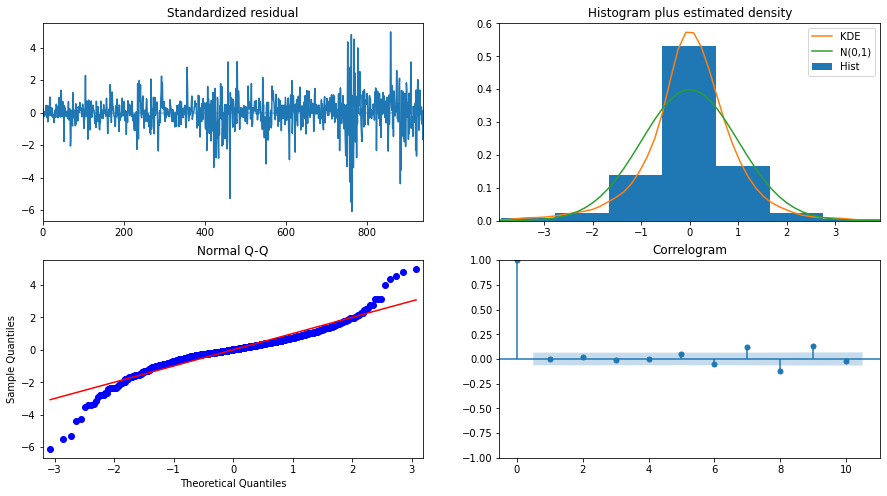

In [11]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [16]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,0))  
fitted = model.fit()  
print(fitted.summary())

RUNNING THE L-BFGS-B CODE

           * * *

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  941
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2341.284
Method:                       css-mle   S.D. of innovations              0.020
Date:                Tue, 01 Mar 2022   AIC                          -4676.568
Time:                        13:07:49   BIC                          -4662.027
Sample:                             1   HQIC                         -4671.025
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.001      2.319      0.020       0.000       0.002
ar.L1.D.Close    -0.1469      0.032     -4.559      0.000      -0.210      -0

/Users/bobbyatkins/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/bobbyatkins/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.48808D+00    |proj g|=  1.17395D-02

At iterate    5    f= -2.48808D+00    |proj g|=  3.77844D-03

At iterate   10    f= -2.48808D+00    |proj g|=  2.13163D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     17      1     0     0   3.109D-07  -2.488D+00
  F =  -2.4880807306264283     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [17]:
# Forecast
fc, se, conf = fitted.forecast(316, alpha=0.05)

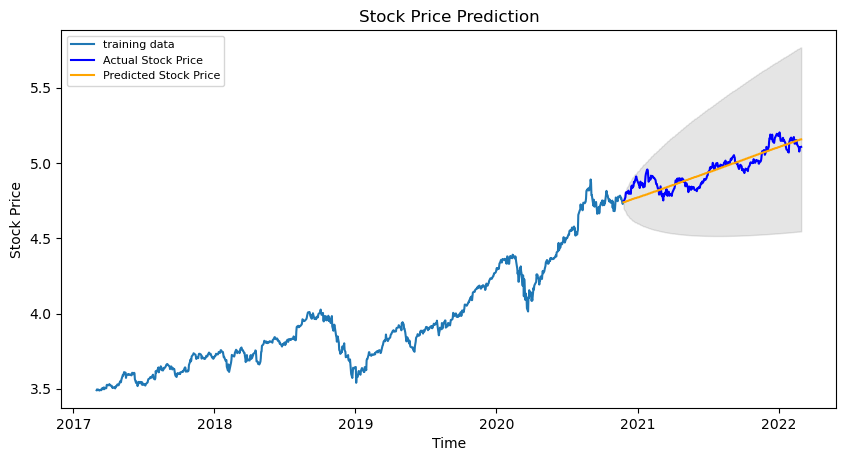

In [18]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0032987166121960575
MAE: 0.04779970922588216
RMSE: 0.057434454922076675
MAPE: 0.00967746596250435
